
# STAT 3210 Project Milestone – Option B: Data Exploration and Modeling  
**Author:** Bing Huang  

This notebook explores housing prices in Portland, Oregon, using a publicly available dataset (e.g., from Redfin or a similar housing data source).  

We will:
1. Load and inspect the dataset  
2. Perform exploratory data analysis (EDA)  
3. Fit baseline and advanced regression models  
4. Briefly evaluate model performance  


## 1. Setup and Imports

In [21]:

# If needed, install any missing packages (uncomment as necessary)
# !pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


## 2. Load the Dataset

In [22]:

data_path = "portland, or prices 2012-2022.csv" 

try:
    df = pd.read_csv(data_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print("File not found. Please check `data_path` and ensure the CSV exists.")
    df = pd.DataFrame()

df.head()


Data loaded successfully!


,Region,Month of Period End,Measure Names,Measure Values
0,"Portland, OR",May 2022,Median Sale Price,577000.0
1,"Portland, OR",July 2022,Median Sale Price,560000.0
2,"Portland, OR",June 2025,Median Sale Price,559900.0
3,"Portland, OR",June 2022,Median Sale Price,555000.0
4,"Portland, OR",April 2022,Median Sale Price,551000.0


## 3. Basic Data Inspection

In [23]:

# Shape of the dataset
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# Column names
print("\nColumns:")
print(df.columns.tolist())

# Data types and non-null counts
print("\nInfo:")
df.info()


Number of rows: 165
Number of columns: 4

Columns:
['Region', 'Month of Period End', 'Measure Names', 'Measure Values']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               165 non-null    object 
 1   Month of Period End  165 non-null    object 
 2   Measure Names        165 non-null    object 
 3   Measure Values       165 non-null    float64
dtypes: float64(1), object(3)
memory usage: 5.3+ KB


In [24]:

# Basic descriptive statistics for numeric columns
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Measure Values,165.0,415830.530303,92487.793107,228500.0,338000.0,420000.0,500000.0,577000.0


## 4. Missing Values

In [25]:

# Count missing values per column
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_counts


Region                 0
Month of Period End    0
Measure Names          0
Measure Values         0
dtype: int64

In [26]:

# Visualize missingness (optional, simple bar plot)
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

if not missing_counts.empty:
    plt.figure(figsize=(8, 4))
    missing_counts.sort_values(ascending=False).plot(kind="bar")
    plt.title("Missing Values per Feature")
    plt.ylabel("Count of Missing Values")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected in the dataset.")


No missing values detected in the dataset.


## 5. Exploratory Data Analysis (EDA)

In [27]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols


['Measure Values']

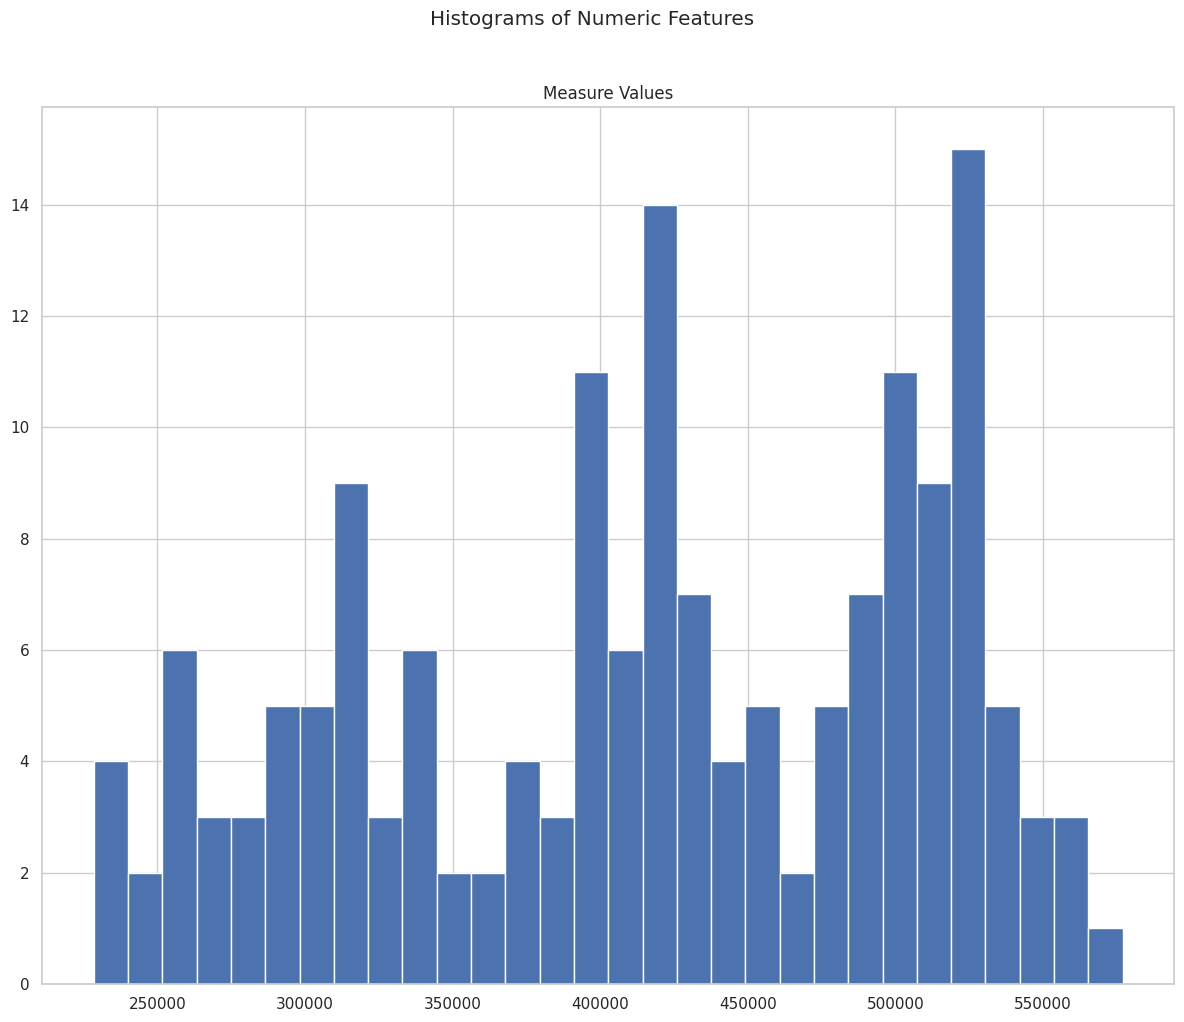

In [28]:

# Histograms for numeric features
if not df.empty and len(numeric_cols) > 0:
    df[numeric_cols].hist(bins=30, figsize=(12, 10))
    plt.suptitle("Histograms of Numeric Features", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns found or dataframe is empty.")


/tmp/ipykernel_3182/3141821969.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


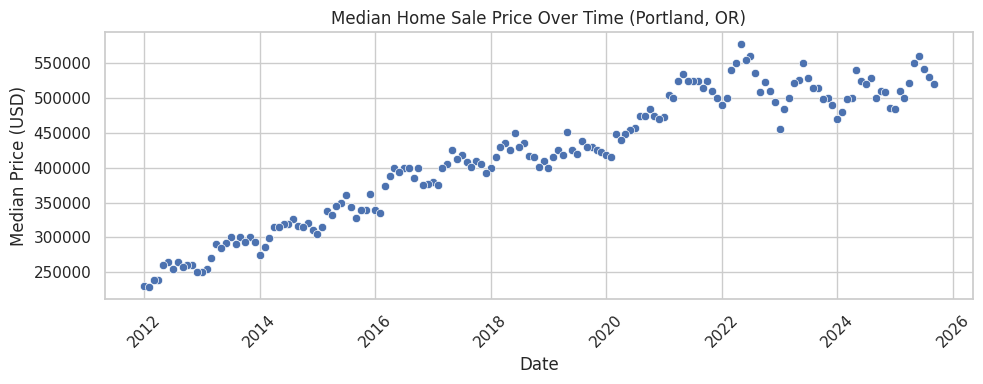

In [29]:
# Your dataset does NOT contain square footage or individual sale prices.
# Instead, it contains a time series: median monthly sale price for Portland, OR.

# Let's rename columns to simpler names:
df = df.rename(columns={
    "Month of Period End": "Date",
    "Measure Values": "median_price"
})

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Scatterplot of Date vs Median Price (really a line plot is better)
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x="Date", y="median_price")
plt.title("Median Home Sale Price Over Time (Portland, OR)")
plt.xlabel("Date")
plt.ylabel("Median Price (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
# Compute correlation matrix on new numeric features
if len(numeric_cols) > 1:
    corr = df_corr[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (Numeric Time-Series Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")


Not enough numeric columns for a correlation heatmap.


## 6. Data Preparation for Modeling

In [31]:
# Create additional numeric features so correlation matrix is meaningful
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Lag features
df["lag1"] = df["median_price"].shift(1)
df["lag3"] = df["median_price"].shift(3)
df["lag12"] = df["median_price"].shift(12)

# Rolling means
df["roll3"] = df["median_price"].rolling(3).mean()
df["roll12"] = df["median_price"].rolling(12).mean()

# % change
df["pct_change"] = df["median_price"].pct_change() * 100

df_corr = df.dropna().copy()

numeric_cols = df_corr.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols

['median_price', 'Year', 'Month', 'lag1', 'lag3', 'lag12', 'roll3', 'roll12', 'pct_change']

['median_price',
 'Year',
 'Month',
 'lag1',
 'lag3',
 'lag12',
 'roll3',
 'roll12',
 'pct_change']

In [32]:

# TODO: Adjust feature/target column names based on your dataset
target_col = "price"  # e.g., 'SalePrice' or similar

# Example set of candidate features (update these)
feature_cols = [
    "square_feet",
    "bedrooms",
    "bathrooms",
    "year_built",
    "lot_size"
]

# Keep only columns that actually exist in the dataframe
feature_cols = [col for col in feature_cols if col in df.columns]

print("Using features:", feature_cols)
print("Target:", target_col)

# Drop rows with missing values in selected columns (simple strategy for milestone)
model_df = df[feature_cols + [target_col]].dropna()

X = model_df[feature_cols]
y = model_df[target_col]

print("Model dataset shape:", X.shape)


Using features: []
Target: price


KeyError: "None of [Index(['price'], dtype='object')] are in the [columns]"

In [ ]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


## 7. Baseline Model – Linear Regression

In [ ]:

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  R^2 : {r2_lr:.3f}")


## 8. Advanced Models – Random Forest and Gradient Boosting

In [ ]:

# Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  R^2 : {r2_rf:.3f}")


In [ ]:

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    random_state=42
)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Gradient Boosting Performance:")
print(f"  RMSE: {rmse_gbr:.2f}")
print(f"  R^2 : {r2_gbr:.3f}")


## 9. Summary and Next Steps


**Summary (Milestone):**  
- Loaded the Portland housing dataset and inspected its structure  
- Performed basic EDA with descriptive statistics and visualizations  
- Trained a baseline Linear Regression model  
- Trained more flexible models (Random Forest and Gradient Boosting) and compared performance  

**Next steps:**  
- Improve feature engineering (e.g., interaction terms, log-transforming price or square footage)  
- Incorporate additional neighborhood-level data if available  
- Tune hyperparameters for the ensemble models  
- Create clearer visualizations to communicate findings in the final project report and presentation  
